In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

from Control_Response_Evaluator import Control_Response_Evaluator

In [2]:
# useful function
def clamp(x, x_min, x_max):
    '''This ensures  x_min <= x <= x_max'''
    return min(x_max, max(x_min, x))

In [3]:

from PID_Controller import PID
from CarParameters import CarParam
from SimulatedCarState import SimulatedCarState

class CarController:
    speed_pid = PID()
    speed_pid.kp = 1.0 # 1.0 for pure P seemds to work well
    
    steer_pid = PID()
    steer_pid.kp = 0.5
    
cre = Control_Response_Evaluator()

controller performance::rise_time:  4.189999999999955  s
controller performance::overshoot:  1.0198271215721988 %
controller performance::settling_time:  5.809999999999921  s


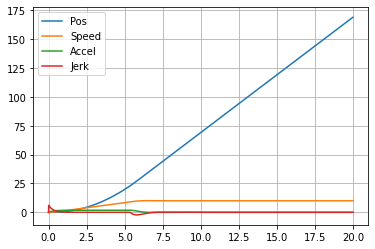

In [4]:
# control the car's steering
dt = 0.01
x = np.array([0, #0 - x position
                0, #1 - x speed
                0, #2 - y position
                0, #3 - y speed 
                0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

carParams = CarParam()
car = SimulatedCarState(x, carParams)
controller = CarController()
controller.speed_pid.kp = 2.0

times = []

poss = []
speeds = []
accels = []
jerks = []

desired_speed = 10.0

t = 0.0
while t < 20.0:
    times.append(t)
    poss.append(car.x[car.xi])
    speeds.append(car.x[car.fsi])
    accels.append(car.x[car.fai])
    jerks.append(car.x[car.fji])
    a_des = controller.speed_pid.tic(car.x[car.fsi], desired_speed)
    car.input_accel(a_des)
    car.tic(dt)
    t += dt

[rise_time, overshoot, settling_time] = cre.evaluate_performance(times, speeds, desired_speed)
print("controller performance::rise_time: ", rise_time, " s")
print("controller performance::overshoot: ", overshoot * 100.0, "%")
print("controller performance::settling_time: ", settling_time, " s")


plt.plot(times, poss, label='Pos')
plt.plot(times, speeds, label='Speed')
plt.plot(times, accels, label='Accel')
plt.plot(times, jerks, label='Jerk')
plt.legend()
plt.grid()
plt.show()


controller performance::rise_time:  1.7700000000000014  s
controller performance::overshoot:  0.05008785364634116 %
controller performance::settling_time:  3.3099999999999734  s


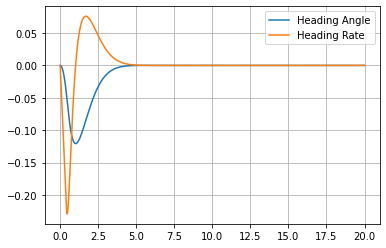

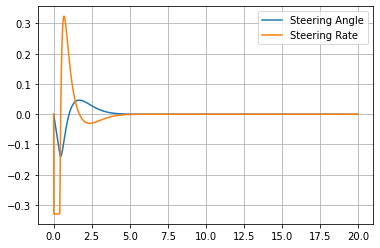

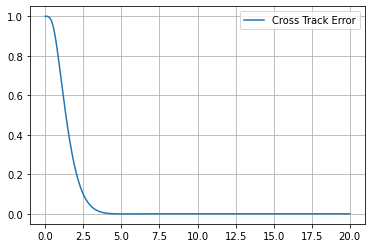

In [5]:

# check the ability to control the car's steering
dt = 0.01
x = np.array([0, #0 - x position
                0, #1 - x speed
                1.0, #2 - y position
                0, #3 - y speed 
              5.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

car = SimulatedCarState(x, carParams)
controller = CarController()
CarController.steer_pid.kp = 4.0
CarController.steer_pid.kd = 100.0
cross_track_error_gain = 4.0
cross_track_error_soft = 1.0

times = []
sas = []
srs = []
has = []
hrs = []
sis = []
ys = []

t = 0.0
heading_des = math.radians(0)
last_cross_track_error = 0.0
cross_track_error_initd = False

while t < 20.0:
    times.append(t)
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    has.append(car.x[car.hai])
    hrs.append(car.x[car.hri])
    
    steer_des = controller.steer_pid.tic(car.x[car.hai], heading_des)
    cross_track_error = car.x[car.yi]
    cross_track_error_correction = math.atan(cross_track_error_gain * cross_track_error / (cross_track_error_soft + car.get_speed()))
    # potentially add a derivative term on cross track error
    
    ys.append(car.x[car.yi])
    sis.append(steer_des + cross_track_error_correction)
    car.input_steering(steer_des - cross_track_error_correction)
    car.tic(dt)
    t += dt

[rise_time, overshoot, settling_time] = cre.evaluate_performance(times, ys, 0.0)
print("controller performance::rise_time: ", rise_time, " s")
print("controller performance::overshoot: ", overshoot * 100.0, "%")
print("controller performance::settling_time: ", settling_time, " s")

plt.plot(times, has, label='Heading Angle')
plt.plot(times, hrs, label='Heading Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, sas, label='Steering Angle')
plt.plot(times, srs, label='Steering Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, ys, label='Cross Track Error')
plt.legend()
plt.grid()
plt.show()

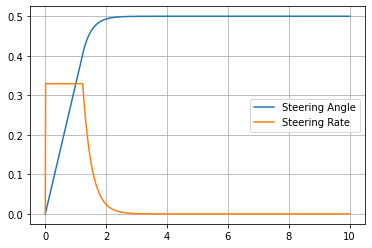

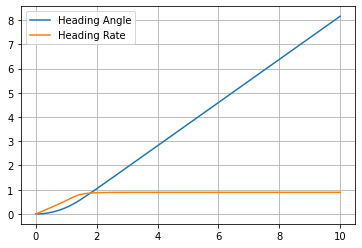

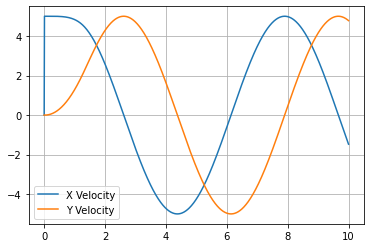

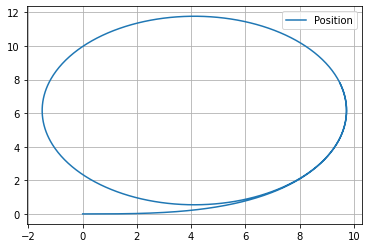

In [6]:
# check the car's steering effects the body
dt = 0.01
x = np.array([0, #0 - x position
                0, #1 - x speed
                0, #2 - y position
                0, #3 - y speed 
              5.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

car = SimulatedCarState(x, carParams)

times = []

sas = []
srs = []
has = []
hrs = []
xs = []
xds = []
ys = []
yds = []

t = 0.0
while t < 10.0:
    times.append(t)
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    has.append(car.x[car.hai])
    hrs.append(car.x[car.hri])
    xs.append(car.x[car.xi])
    xds.append(car.x[car.xdi])
    ys.append(car.x[car.yi])
    yds.append(car.x[car.ydi])
    
    
    car.input_steering(0.5)
    car.tic(dt)
    t += dt

plt.plot(times, sas, label='Steering Angle')
plt.plot(times, srs, label='Steering Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, has, label='Heading Angle')
plt.plot(times, hrs, label='Heading Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, xds, label='X Velocity')
plt.plot(times, yds, label='Y Velocity')
plt.legend()
plt.grid()
plt.show()

plt.plot(xs, ys, label='Position')
plt.legend()
plt.grid()
plt.show()


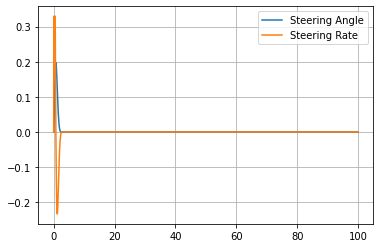

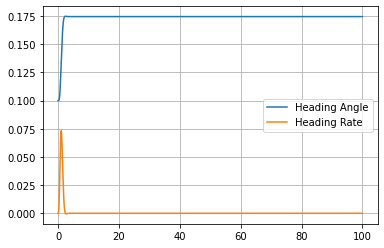

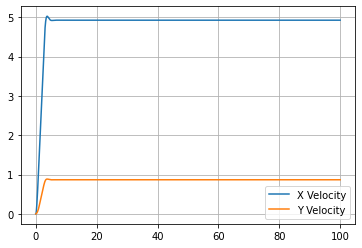

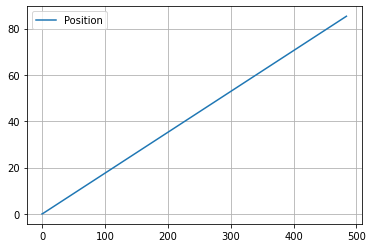

In [7]:
# create a straight piece of track and see if the car can follow it at a desired 
# speed. To keep it simple, track is a horizontal line

desired_heading = math.radians(10.0)
p0 = [0,0]
p1 = [100,0]
dist = 100.0
uv = [1.0, 0.0]
desired_speed = 5.0

# check the car's steering effects the body
dt = 0.01
x = np.array([0, #0 - x position
                0, #1 - x speed
                0, #2 - y position
                0, #3 - y speed 
              0.0, #4 - forward speed
                0, #5 - forward acceleration
                0, #6 - forward jerk
                0.1, #7 - heading angle
                0, #8 - heading rate
                0, #9 - steering angle
                0]) #10 - steering rate

car = SimulatedCarState(x, carParams)

times = []

sas = []
srs = []
has = []
hrs = []
xs = []
xds = []
ys = []
yds = []

t = 0.0
while t < 100.0:
    times.append(t)
    sas.append(car.x[car.sai])
    srs.append(car.x[car.sri])
    has.append(car.x[car.hai])
    hrs.append(car.x[car.hri])
    xs.append(car.x[car.xi])
    xds.append(car.x[car.xdi])
    ys.append(car.x[car.yi])
    yds.append(car.x[car.ydi])
    
    steer_des = controller.steer_pid.tic(car.x[car.hai], desired_heading)
    car.input_steering(steer_des)
    a_des = controller.speed_pid.tic(car.x[car.fsi], desired_speed)
    car.input_accel(a_des)
    car.tic(dt)
    t += dt

plt.plot(times, sas, label='Steering Angle')
plt.plot(times, srs, label='Steering Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, has, label='Heading Angle')
plt.plot(times, hrs, label='Heading Rate')
plt.legend()
plt.grid()
plt.show()

plt.plot(times, xds, label='X Velocity')
plt.plot(times, yds, label='Y Velocity')
plt.legend()
plt.grid()
plt.show()

plt.plot(xs, ys, label='Position')
plt.legend()
plt.grid()
plt.show()

